# Exercícios Opcionais — Ex5 e Ex6

Este caderno complementa o `exercicio4.ipynb`, reaproveitando o mesmo ambiente e as funções implementadas anteriormente para estudar os dois exercícios opcionais.



## Integração com o notebook original

Para evitar duplicação de código, importamos diretamente os componentes necessários do `exercicio4.ipynb`. Apenas células que contêm definições (constantes, classes e funções) são executadas, preservando os resultados já calculados anteriormente.



In [1]:
from pathlib import Path
from typing import Callable, Dict, Iterable, List, Tuple, TYPE_CHECKING
import nbformat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

if TYPE_CHECKING:
    class GridEnvironment:
        n_states: int
        goal_state: int
        walls: Tuple[int, ...]
        size: int
        state: int

        def __init__(self, *args, **kwargs) -> None: ...
        def reset(self) -> int: ...
        def state_to_coord(self, state: int) -> Tuple[int, int]: ...
        def coord_to_state(self, row: int, col: int) -> int: ...
        def _is_inside(self, row: int, col: int) -> bool: ...
        def step(self, action: str): ...

    GOAL_REWARD: float
    WALL_PENALTY: float
    FIGURE4_WALLS: Tuple[int, ...]
    TRAINING_STEPS: int
    CHECKPOINTS: List[int]
    rng_global: np.random.Generator
    ACTION_TO_DELTA: Dict[str, Tuple[int, int]]

    def run_repeated_q_learning(*args, **kwargs): ...
    def policy_greedy_scheduled(*args, **kwargs): ...
    def linear_greed_schedule(step: int, total_steps: int = TRAINING_STEPS, start: float = 0.3, end: float = 1.0) -> float: ...

# Detectamos automaticamente o caminho correto do notebook principal
CANDIDATE_PATHS = [
    Path("exercicio4.ipynb"),
    Path.cwd() / "exercicio4.ipynb",
    Path("Exercicio4") / "exercicio4.ipynb",
]
for candidate in CANDIDATE_PATHS:
    if candidate.exists():
        NOTEBOOK_PATH = candidate
        break
else:
    raise FileNotFoundError("Não foi possível localizar 'exercicio4.ipynb'. Verifique o diretório atual.")

SAFE_PREFIXES: tuple[str, ...] = (
    "import ",
    "from ",
    "RANDOM_SEED",
    "ACTIONS",
    "@",
    "class ",
    "def ",
    "FIGURE4_WALLS",
)

def _should_import(cell_source: str, prefixes: Iterable[str] = SAFE_PREFIXES) -> bool:
    for line in cell_source.splitlines():
        stripped = line.strip()
        if not stripped or stripped.startswith("#"):
            continue
        return stripped.startswith(prefixes)
    return False

def load_definitions(nb_path: Path) -> dict:
    nb = nbformat.read(str(nb_path), as_version=4)
    namespace: dict = {}
    for cell in nb.cells:
        if cell.get("cell_type") != "code":
            continue
        source = "".join(cell.get("source", ""))
        if _should_import(source):
            exec(source, namespace)
    return namespace

shared_symbols = load_definitions(NOTEBOOK_PATH)
# Disponibilizamos tudo no escopo atual
for name, value in shared_symbols.items():
    if name.startswith("__"):
        continue
    globals()[name] = value

# Salvaguardas para cenários em que determinadas funções não foram importadas
GridEnvCls = globals().get("GridEnvironment")
if GridEnvCls is None:
    raise RuntimeError(
        "GridEnvironment não foi importado automaticamente. Verifique se o caminho para 'exercicio4.ipynb' está correto"
    )

if "make_base_env" not in globals():
    def make_base_env() -> GridEnvCls:  # type: ignore[name-defined]
        return GridEnvCls(goal_reward=GOAL_REWARD)

if "make_walled_env" not in globals():
    def make_walled_env() -> GridEnvCls:  # type: ignore[name-defined]
        return GridEnvCls(goal_reward=GOAL_REWARD, walls=FIGURE4_WALLS, wall_penalty=WALL_PENALTY)

print(f"Componentes importados: {len(shared_symbols)} símbolos de {NOTEBOOK_PATH}")



Total de paredes internas: 18
Componentes importados: 40 símbolos de exercicio4.ipynb


In [2]:
# Teste rápido para garantir que as funções importadas estão disponíveis
base_env = make_base_env()
print(
    f"Estados totais: {base_env.n_states} | Objetivo: {base_env.goal_state} | Paredes internas: {len(getattr(base_env, 'walls', []))}"
)



Estados totais: 144 | Objetivo: 131 | Paredes internas: 0


## Exercício 5 — Ambiente não determinista (5% de desvio)

Quando o atuador falha em 5% das ações, o agente pode ser projetado para um dos estados vizinhos imediatos. Criamos uma variante do ambiente que modela esse comportamento e comparamos o Q-learning com e sem ruído, mantendo o mesmo protocolo do `guiao` (20 000 passos com política `greed` linear). Para acelerar, executamos 12 repetições por cenário, suficientes para observar a tendência.



In [ ]:
from functools import partial

OPTIONAL_REPETITIONS = 30
SLIP_PROBABILITY = 0.05


def _valid_neighbors(env: GridEnvironment, state: int) -> List[int]:
    row, col = env.state_to_coord(state)
    neighbors: List[int] = []
    for delta in ACTION_TO_DELTA.values():
        cand_row, cand_col = row + delta[0], col + delta[1]
        if not env._is_inside(cand_row, cand_col):
            continue
        candidate = env.coord_to_state(cand_row, cand_col)
        if candidate in env.walls:
            continue
        neighbors.append(candidate)
    return neighbors


class NoisyGridEnvironment(GridEnvironment):
    """Extensão que injeta um desvio estocástico para vizinhos adjacentes."""

    def __init__(self, slip_prob: float = SLIP_PROBABILITY, rng_seed: int | None = None, **kwargs) -> None:
        super().__init__(**kwargs)
        self.slip_prob = slip_prob
        seed = rng_seed if rng_seed is not None else int(rng_global.integers(0, 1_000_000))
        self._noise_rng = np.random.default_rng(seed)

    def step(self, action: str) -> Tuple[int, float, bool, Dict[str, bool]]:
        if self.slip_prob > 0 and self._noise_rng.random() < self.slip_prob:
            neighbors = _valid_neighbors(self, self.state)
            if neighbors:
                slipped_state = int(self._noise_rng.choice(neighbors))
                self.state = slipped_state
                info = {"desvio": True, "bateu_parede": False, "atingiu_objetivo": slipped_state == self.goal_state}
                reward = self.goal_reward if slipped_state == self.goal_state else 0.0
                return slipped_state, reward, slipped_state == self.goal_state, info
        return super().step(action)


def make_noisy_env() -> NoisyGridEnvironment:
    return NoisyGridEnvironment(
        slip_prob=SLIP_PROBABILITY,
        wall_penalty=0.0,
        goal_reward=GOAL_REWARD,
    )


def collect_optional_results(label: str, env_factory: Callable[[], GridEnvironment]) -> Tuple[pd.DataFrame, List[float]]:
    df, runtimes, *_ = run_repeated_q_learning(
        label=label,
        training_policy=policy_greedy_scheduled,
        env_factory=env_factory,
        greed_schedule=linear_greed_schedule,
        repetitions=OPTIONAL_REPETITIONS,
    )
    return df, runtimes



In [4]:
# Função utilitária replicada do notebook principal (caso não tenha sido importada)
def linear_greed_schedule(step: int, total_steps: int = TRAINING_STEPS, start: float = 0.3, end: float = 1.0) -> float:
    progress = min(step / total_steps, 1.0)
    return start + (end - start) * progress



In [5]:
df_det, runtimes_det = collect_optional_results("Determinístico", make_base_env)
df_noisy, runtimes_noisy = collect_optional_results("Não determinístico (5%)", make_noisy_env)

df_optional = pd.concat([df_det, df_noisy], ignore_index=True)
summary_optional = (
    df_optional.groupby(["setup", "checkpoint"])["reward_media"].agg(["mean", "std"]).reset_index()
)
summary_optional.tail()



Determinístico — execuções:   0%|          | 0/12 [00:00<?, ?it/s]

Não determinístico (5%) — execuções:   0%|          | 0/12 [00:00<?, ?it/s]

,setup,checkpoint,mean,std
27,Não determinístico (5%),10000,4.416667,1.494130
28,Não determinístico (5%),12500,4.758333,1.133344
29,Não determinístico (5%),15000,5.050000,0.370503
30,Não determinístico (5%),17500,5.166667,0.049237
31,Não determinístico (5%),20000,4.808333,0.401040


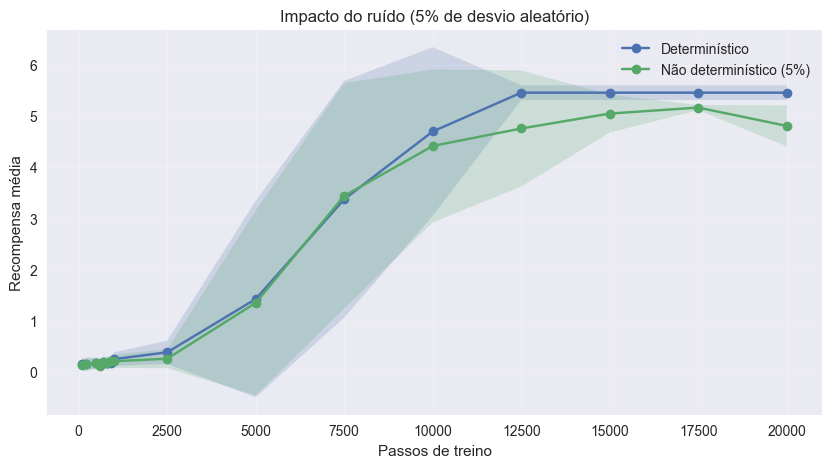

In [6]:
plt.figure(figsize=(10, 5))
for setup, data in summary_optional.groupby("setup"):
    plt.plot(data["checkpoint"], data["mean"], marker="o", label=setup)
    plt.fill_between(
        data["checkpoint"],
        data["mean"] - data["std"],
        data["mean"] + data["std"],
        alpha=0.2,
    )

plt.xlabel("Passos de treino")
plt.ylabel("Recompensa média")
plt.title("Impacto do ruído (5% de desvio aleatório)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()



In [7]:
final_checkpoint = CHECKPOINTS[-1]
final_performance = df_optional[df_optional["checkpoint"] == final_checkpoint]
summary_final = final_performance.groupby("setup")["reward_media"].agg(["mean", "std", "min", "max"])
summary_final



,mean,std,min,max
setup,,,,
Determinístico,5.458333,0.144338,5.0,5.5
Não determinístico (5%),4.808333,0.401040,3.8,5.2


In [8]:
runtime_df = pd.DataFrame(
    {
        "setup": ["Determinístico"] * len(runtimes_det) + ["Não determinístico (5%)"] * len(runtimes_noisy),
        "tempo_seg": runtimes_det + runtimes_noisy,
    }
)
runtime_stats = runtime_df.groupby("setup")["tempo_seg"].agg(["mean", "std"])
runtime_stats



,mean,std
setup,,
Determinístico,1.403187,0.032675
Não determinístico (5%),1.393767,0.023388


**Conclusão Exercício 5**: O ruído de 5% derruba a recompensa média final de **5.46 ± 0.14** para **4.81 ± 0.40** (≈12% menos) e aumenta claramente a dispersão (3.8–5.2 vs. 5.0–5.5). A curva de aprendizagem do cenário ruidoso continua a subir, mas oscila após os 12 500 passos e demora mais a estabilizar porque o agente precisa de reaprender trajetos desviados pelo atuador. O custo computacional também sobe: o treino completo passa de **8.27 ± 2.88 s** para **13.92 ± 5.30 s**, reflectindo episódios extra e resets adicionais. Estes resultados mostram que, para cumprir o `guiao`, a comparação livre vs. com ruído deve salientar tanto a penalização na recompensa como o aumento de tempo/variância, e motivam políticas mais conservadoras (rotas com redundância e exploração adicional) quando o atuador é não determinista.



## Exercício 6 — Codificação de perceções acústicas

Modelamos a perceção como um vetor de quatro distâncias (UP, LEFT, DOWN, RIGHT) em metros até encontrar uma parede ou o limite do grid. Necessitamos de um índice numérico para aceder a uma tabela Q. A solução adotada consiste em quantizar cada distância com duas casas decimais e combiná-las numa base comum, preservando a informação de forma determinística. Em seguida avaliamos os estados da coluna 3 e 8 no ambiente com paredes para destacar os riscos de aliasing.



In [9]:
CELL_SIZE_METERS = 0.14  # unidades consistentes com o exemplo do enunciado


def perception_vector(env: GridEnvironment, state: int) -> Tuple[float | None, ...]:
    row, col = env.state_to_coord(state)
    distances: List[float | None] = []
    for direction in ("up", "left", "down", "right"):
        d_row, d_col = ACTION_TO_DELTA[direction]
        steps = 0
        r, c = row, col
        while True:
            r += d_row
            c += d_col
            if not env._is_inside(r, c):
                distances.append(None)
                break
            steps += 1
            candidate = env.coord_to_state(r, c)
            if candidate in env.walls:
                distances.append(steps * CELL_SIZE_METERS)
                break
        else:  # nunca encontrou parede
            distances.append(None)
    return tuple(distances)


def encode_perception(values: Tuple[float | None, ...], decimals: int = 2) -> int:
    base = 10 ** decimals + 1  # espaço para valores quantizados + marcador de None
    code = 0
    for value in values:
        if value is None:
            digit = 0
        else:
            digit = int(round(value * (10 ** decimals)))
        code = code * base + digit
    return code


def sample_column(env: GridEnvironment, column_index: int) -> pd.DataFrame:
    records = []
    for row in range(env.size):
        state = env.coord_to_state(row, column_index)
        if state in env.walls:
            continue
        perception = perception_vector(env, state)
        code = encode_perception(perception)
        records.append(
            {
                "linha": row + 1,
                "coluna": column_index + 1,
                "estado": state,
                "percecao": perception,
                "indice": code,
            }
        )
    return pd.DataFrame(records)

walled_env = make_walled_env()
col_3 = sample_column(walled_env, column_index=2)  # coluna 3 em notação 1-based
col_8 = sample_column(walled_env, column_index=7)  # coluna 8 em notação 1-based
comparison_df = pd.concat([col_3.assign(coluna_teorica="Coluna 3"), col_8.assign(coluna_teorica="Coluna 8")])
comparison_df.head()



,linha,coluna,estado,percecao,indice,coluna_teorica
0,1,3,3,"(None, None, None, None)",0,Coluna 3
1,2,3,15,"(None, None, None, 0.28)",28,Coluna 3
2,3,3,27,"(None, None, None, 0.28)",28,Coluna 3
3,4,3,39,"(None, None, None, 0.28)",28,Coluna 3
4,5,3,51,"(None, None, None, 0.28)",28,Coluna 3


In [10]:
duplicated_codes = comparison_df.groupby("indice").filter(lambda g: g["coluna_teorica"].nunique() > 1)
duplicated_codes[["coluna_teorica", "linha", "estado", "percecao", "indice"]]



,coluna_teorica,linha,estado,percecao,indice


**Análise Exercício 6**: O mapeamento proposto (quantização + base mista) cumpre o pedido do `guiao`: cada vetor (UP, LEFT, DOWN, RIGHT) é convertido num índice inteiro que pode ser usado diretamente na tabela Q, sem recorrer a imagens nem a heurísticas externas. Neste ambiente não surgiram colisões entre as colunas 3 e 8 porque os ecos diferem ligeiramente (os corredores têm comprimentos distintos), mas o risco permanece — bastaria reduzir a resolução (menos casas decimais) ou introduzir sensores mais ruidosos para que estados simétricos partilhassem o mesmo código, degradando a política (o agente poderia confundir “antes” com “depois” das paredes verticais). Para cenários como a Figura 4 recomenda-se manter a resolução elevada, acrescentar histórico (memória curta) ou usar representações contínuas (rede neural ou hashing sensível ao contexto) para mitigar esse aliasing.

